# Injection campaign

In this notebook we set an injection campaign to compute the selection effects of a given detector

In [1]:
#IMPORT
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.integrate import cumtrapz, trapz
from tqdm import tqdm
import time
import scipy.stats as stats
import h5py

#PYTHON MODULES
from spectral_sirens.utils.constants import *
from spectral_sirens.cosmology import gwcosmo
from spectral_sirens.gw_population import gwpop
from spectral_sirens.utils import gwutils
from spectral_sirens.utils import utils
from spectral_sirens.detectors import sensitivity_curves as sc

#Directories
import os 
PATH = os.getcwd()
dir_out = 'data_injections/'

#PLOTS
from matplotlib.ticker import ScalarFormatter
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
fontSz = 15
fontsz = 13
fontssz = 11

new_colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728',
              '#9467bd', '#8c564b', '#e377c2', '#7f7f7f',
              '#bcbd22', '#17becf']

We load our fiducial universe parameters

In [3]:
from fiducial_universe_gwtc3 import *

Settings for the sensitivity of our detector

In [4]:
fmin = 10.
#detector = 'A#' 
detector = 'CE-40' 
detectorSn, fmin_detect, fmax_detect = sc.detector_psd(detector)
based = 'ground'
snr_th = 8.

## Horizon distance plot

Find maximum detectable luminosity distance for equal mass binaries

*Note:* readjust the maximum luminosity distance depending on the detector sensitivity

Maximum horizon distance 1010199.7049750861  Mpc
Maximum horizon redshift 78.99752611052425
Maximum horizon redshift with h0= 0.2   25.309190778981208
Maximum horizon redshift with h0= 1.2   137.59206366744422


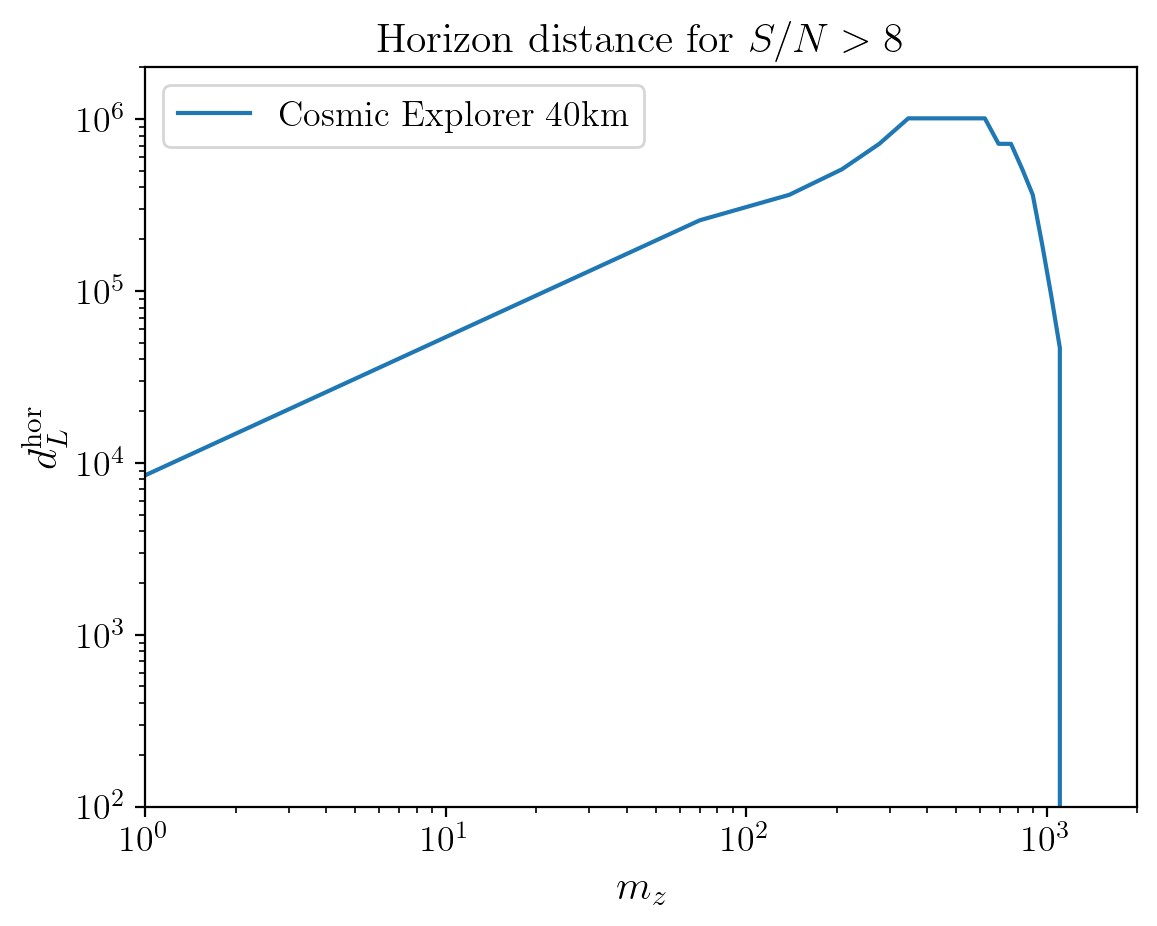

In [5]:
mz_min,mz_max = 1.0, 2000.#500.0
#log10dL_min,log10dL_max = np.log10(1e2), np.log10(1e5)
log10dL_min,log10dL_max = np.log10(1e2), np.log10(2e6)

n_grid = 30
mzs = np.linspace(mz_min,mz_max,n_grid)
log10dLs = np.linspace(log10dL_min,log10dL_max,n_grid)

MZ, LOG10DL = np.meshgrid(mzs,log10dLs)
DL = 10.**LOG10DL
SNR = gwutils.vsnr_from_psd(MZ,MZ,DL,fmin,Tobs_fid,detectorSn, fmin_detect, fmax_detect,based)

MZ_detected = MZ[SNR>snr_th]
DL_detected = DL[SNR>snr_th]


dL_horizon = np.zeros(n_grid)
for i in range(n_grid):
    if len(DL[SNR[:,i]>snr_th,i])>0:
        dL_horizon[i] = DL[SNR[:,i]>snr_th,i][-1]

print('Maximum horizon distance',np.max(dL_horizon),' Mpc')
print('Maximum horizon redshift',gwcosmo.z_at_dl_approx(np.max(dL_horizon),H0_fid,Om0_fid))
H0_low = 20.
print('Maximum horizon redshift with h0=',H0_low/100,' ',gwcosmo.z_at_dl_approx(np.max(dL_horizon),H0_low,Om0_fid))
H0_high = 120.
print('Maximum horizon redshift with h0=',H0_high/100,' ',gwcosmo.z_at_dl_approx(np.max(dL_horizon),H0_high,Om0_fid))

#Plot
plt.loglog(mzs,dL_horizon,label=sc.detector_name(detector))
plt.xlabel(r'$m_z$',fontsize=fontSz)
plt.ylabel(r'$d_L^\mathrm{hor}$',fontsize=fontSz)
plt.title(r'Horizon distance for $S/N > 8$',fontsize=fontSz)
plt.xlim([mz_min,mz_max])
plt.ylim([10**log10dL_min,10**log10dL_max])
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.legend(loc='best',fontsize=fontsz)
plt.show()

When starting an injection campaign to compute the sensitivity of a given detector we need to sample detector frame masses and luminosity distances from some fiducial distributions.

We sample in :
- Uniform comoving volume up to a maximum redshift
- Power law for detector primary mass in a given mass range
- Uniforma mass ratio

In [13]:
params = 'm1z_m2z_dL'

#zmin_inj, zmax_inj = 1e-3, 15
zmin_inj, zmax_inj = 1e-3, 115
mmin_inj, mmax_inj = 1e-1, 100.
alpha_inj, mzmin_inj, mzmax_inj = -0.2, mmin_inj, mmax_inj*(1+zmax_inj)

#BNS CE
#zmin_inj, zmax_inj = 1e-3, 50. ?
#mmin_inj, mmax_inj = 0.01., 20.

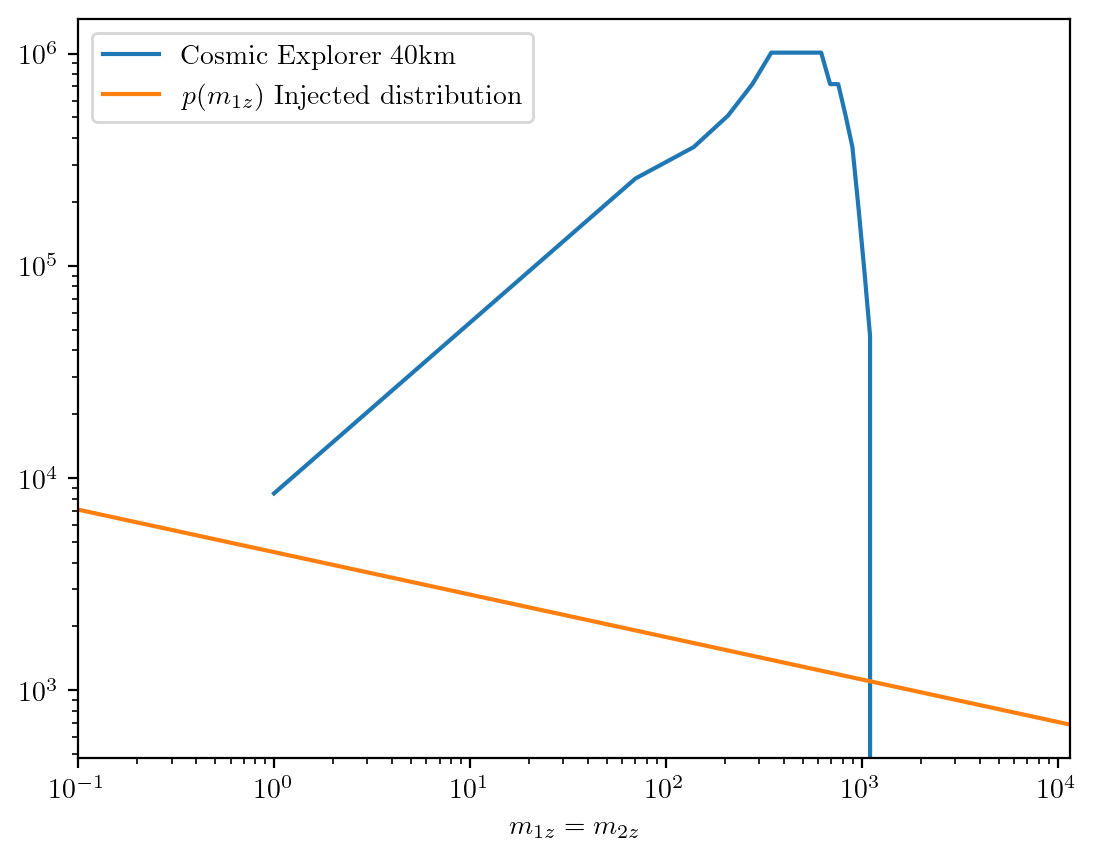

In [14]:
plt.loglog(mzs,dL_horizon,label=sc.detector_name(detector))

mzs_inj = np.linspace(mzmin_inj,mzmax_inj,n_grid)
plt.loglog(mzs_inj,1e7*utils.powerlaw(mzs_inj,mzmin_inj,mzmax_inj,alpha_inj),label=r'$p(m_{1z})$ Injected distribution')

plt.xlim([mzmin_inj,mzmax_inj])
plt.xlabel(r'$m_{1z}=m_{2z}$')
plt.legend()
plt.show()

It is also informative to see how many mergers there are as a function of redshift assuming that the merger rate follows the star formation rate.

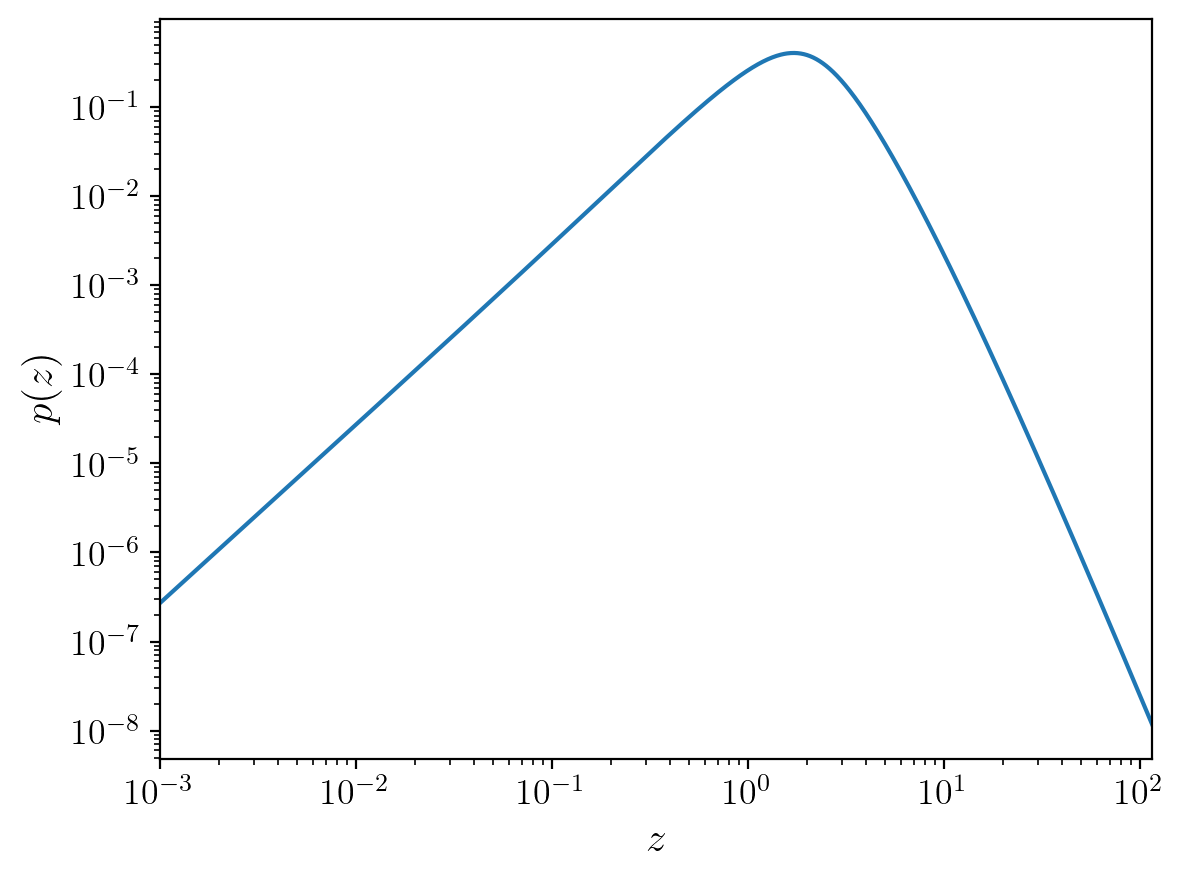

In [7]:
zs = np.linspace(zmin_inj,zmax_inj,10000)
pz = gwcosmo.diff_comoving_volume_approx(zs,H0_fid,Om0_fid)*gwpop.rate_z(zs,zp_fid,alpha_z_fid,beta_fid)/(1+zs)
pz = pz/trapz(pz,zs)

plt.loglog(zs,pz)
plt.xlabel(r'$z$',fontsize=fontSz)
plt.ylabel(r'$p(z)$',fontsize=fontSz)
plt.xlim([zmin_inj,zmax_inj])
plt.tick_params(axis='both', which='major', labelsize=fontsz)
plt.show()

For the injections we want to:

- which injections are detected, as determined by observed SNR* larger than a fixed threshold
- the probability of each draw given the injected distributions

For the detector frame masses we are sampling with a power-law in the primary mass:

$$p(m_{1z})=\frac{(1+\alpha)}{(m_{1z,max})^{(1+\alpha)}-(m_{1z,min})^{(1+\alpha)}}m_{1z}^\alpha$$

, and uniform in the mass ratio:

$$p(q)=1$$

Since we are sampling uniformly in $\log_{10} d_L$ we need to include a Jacobian to transform to $d_L$:

$$p(d_L)=p'(\log_{10} d_L)|\frac{\partial \log_{10} d_L}{\partial d_L}|=\frac{1}{(\log_{10}d_{L}^{max}-\log_{10}d_L^{min})}\frac{\log_{10}e}{d_L}$$

In total

$$p_{draw}(m_{1z},d_L)=p(m_{1z})p(m_{2z})p(d_L)$$

The observed SNR is defined as a random instance of a normal distribution centered at the true SNR with variance 1. 

The true SNR is computed from the optimal SNR multiplied by the geometrical factor accounting for the random sky postion, inclination and polarization for a given detector network.

We do injections for $m_{1z}$, $m_{2z}$ and $d_L$

In [94]:
n_detections = int(1e1)
n_sources = n_detections*50


starttime = time.time()

##Defining the injected distribution CDFs
#----
#Detector frame primary mass
m1zs = np.linspace(mzmin_inj,mzmax_inj,10000)
cdf_m1z = cumtrapz(gwpop.power_law(m1zs,alpha_inj, mzmin_inj,mzmax_inj),m1zs,initial=0.0)
cdf_m1z = cdf_m1z / cdf_m1z[-1]
#Redshift
zs = np.linspace(zmin_inj,zmax_inj,10000)
cdf_z = cumtrapz(gwcosmo.diff_comoving_volume_approx(zs,H0_fid,Om0_fid)/(1+zs),zs,initial=0.0)
norm_z = cdf_z[-1]
cdf_z = cdf_z / norm_z
#Geometric factor from orientations
ww = np.linspace(0.0,1.0,1000)
cdf_ww = 1.0-sc.pw_hl(ww)

##Computing injected events
#----
#Detector frame primary mass
m1z_mock_pop = utils.inverse_transf_sampling(cdf_m1z,m1zs,n_sources)
m2z_mock_pop = np.random.uniform(mzmin_inj,m1z_mock_pop,n_sources)
#Luminosity distance
z_mock_pop = utils.inverse_transf_sampling(cdf_z,zs,n_sources)
dL_mock_pop = gwcosmo.dL_approx(z_mock_pop,H0_fid,Om0_fid) #Mpc

#Optimal SNR
snr_opt_mock_pop = gwutils.vsnr_from_psd(m1z_mock_pop,m2z_mock_pop,dL_mock_pop,fmin,Tobs_fid,detectorSn, fmin_detect, fmax_detect,based)
#True SNR
w_mock_pop = utils.inverse_transf_sampling(cdf_ww,ww,n_sources) #random draw
snr_true_mock_pop = snr_opt_mock_pop*w_mock_pop
#Observed SNR
snr_obs_mock_pop = gwutils.observed_snr(snr_true_mock_pop)

##Computing p_draw
p_draw_m1z = gwpop.power_law(m1z_mock_pop,alpha_inj, mzmin_inj,mzmax_inj)
p_draw_m2z = 1./(m1z_mock_pop-mzmin_inj)
p_draw_z = gwcosmo.diff_comoving_volume_approx(z_mock_pop,H0_fid,Om0_fid)/(1+z_mock_pop)/norm_z
Ez_i = gwcosmo.Ez_inv(z_mock_pop,H0_fid,Om0_fid)
D_H = (Clight/1.0e3)  / H0_fid #Mpc 
jac_logdLz = dL_mock_pop/(1.+z_mock_pop) + (1. + z_mock_pop)*D_H * Ez_i #Mpc
p_draw_mock_pop = p_draw_m1z * p_draw_m2z * p_draw_z / jac_logdLz

#Detected injections
m1z_inj = m1z_mock_pop[snr_obs_mock_pop>snr_th]
m2z_inj = m2z_mock_pop[snr_obs_mock_pop>snr_th]
dL_inj = dL_mock_pop[snr_obs_mock_pop>snr_th]
p_draw_inj = p_draw_mock_pop[snr_obs_mock_pop>snr_th]

Ndet = np.size(m1z_inj)
Ndraws = n_sources
print('Ndet = ',Ndet,', Ndraw = ',Ndraws)

print('Time taken = {} seconds'.format(time.time() - starttime))

Ndet =  82 , Ndraw =  500
Time taken = 0.7684361934661865 seconds


In [ ]:
inj_details = 'Vz_zmax_%s_m1z_power_law_alpha_%s_mmin_%s_mmax_%s' % (zmax_inj,alpha_inj,mmin_inj,mmax_inj)

# Saving the data
variables = ['m1z_inj','m2z_inj','dL_inj','p_draw_inj']
with h5py.File(dir_out+'injections_'+detector+'_'+params+'_'+inj_details+'_Ndraws_%s_Ndet_%s.hdf5' % (Ndraws,Ndet), "w") as f:
    for var in variables:
        dset = f.create_dataset(var, data=eval(var))